In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [91]:
df = pd.read_csv('Taz_Water.csv')

# Unnessary Columns for preditive model

In [92]:
pred_uncol = ['date_recorded','funder','installer','longitude','latitude','wpt_name','num_private','subvillage'
              ,'recorded_by','scheme_name','ward','public_meeting',
             'extraction_type','payment','quality_group','source_type','quantity',
             'waterpoint_type_group','permit']

In [93]:
pred_df = df.drop(pred_uncol,axis=1)
pred_df.head()

,id,amount_tsh,gps_height,basin,region,region_code,district_code,lga,population,scheme_management,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,status_group
0,69572,6000.0,1390,Lake Nyasa,Iringa,11,5,Ludewa,109,VWC,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,1399,Lake Victoria,Mara,20,2,Serengeti,280,Other,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,686,Pangani,Manyara,21,4,Simanjiro,250,VWC,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,58,VWC,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,0,Lake Victoria,Kagera,18,1,Karagwe,0,NaN,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


# Checking each columns

In [94]:
dd = pred_df.drop('id',axis=1)
dd.isna().sum()

amount_tsh                  0
gps_height                  0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
population                  0
scheme_management        3877
construction_year           0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [95]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   basin                  59400 non-null  object 
 3   region                 59400 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   lga                    59400 non-null  object 
 7   population             59400 non-null  int64  
 8   scheme_management      55523 non-null  object 
 9   construction_year      59400 non-null  int64  
 10  extraction_type_group  59400 non-null  object 
 11  extraction_type_class  59400 non-null  object 
 12  management             59400 non-null  object 
 13  management_group       59400 non-null  object 
 14  payment_type           59400 non-null  object 
 15  wa

In [96]:
dd['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

# Train test split

In [97]:
X = dd.drop('status_group',axis=1)
y = dd['status_group']

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# fixing the missing data

In [99]:
X_train["scheme_management"].fillna("VWC", inplace = True)
X_train['construction_year'] = X_train['construction_year'].replace(0,np.nan)
X_train['construction_year'] = X_train['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Test

In [100]:
X_test["scheme_management"].fillna("VWC", inplace = True)
X_test['construction_year'] = X_test['construction_year'].replace(0,np.nan)
X_test['construction_year'] = X_test['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Pipe lines

In [101]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes(['int','float']).columns


numeric_pipe = Pipeline([('numnorm',StandardScaler())])

nominal_pipe = Pipeline([
    ('onehotenc', OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ('onehotnorm', StandardScaler())
])

In [102]:
ct = ColumnTransformer([
    ('numpipe',numeric_pipe, num_cols),
    ('nominalpipe',nominal_pipe,cat_cols),
])
ct

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  StandardScaler())]),
                                 Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])

In [103]:
log = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',LogisticRegression(random_state=42))
])
log

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   StandardScaler())]),
                                                  Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

# Fit the Model

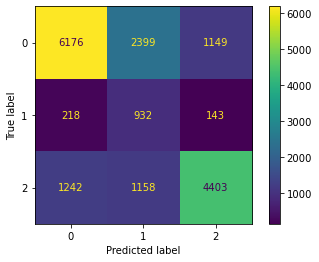

In [104]:
log.fit(X_train,y_train)
y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

In [105]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.64      0.71      9724
functional needs repair       0.21      0.72      0.32      1293
         non functional       0.77      0.65      0.70      6803

               accuracy                           0.65     17820
              macro avg       0.60      0.67      0.58     17820
           weighted avg       0.75      0.65      0.68     17820



# Checking is overfitting

In [106]:
print(log.score(X_train,y_train))
print(log.score(X_test,y_test))

0.6553872053872054
0.645959595959596


# AUC

In [107]:
from sklearn.metrics import roc_auc_score

y_score = log.fit(X_train, y_train).predict_proba(X_test)



micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
)

In [108]:
micro_roc_auc_ovr

0.8408473783717069

# Grid Search 

In [110]:
from sklearn.model_selection import GridSearchCV
pipe_grid = dict()
pipe_grid['model__solver'] = ['lbfgs', 'liblinear']
pipe_grid['model__penalty'] = ['l1', 'l2', 'elasticnet']
pipe_grid['model__C'] = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

In [111]:
pipe_grid 

{'model__solver': ['lbfgs', 'liblinear'],
 'model__penalty': ['l1', 'l2', 'elasticnet'],
 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [88]:
gs_pipe = GridSearchCV(estimator=log,
                      param_grid=pipe_grid)
gs_pipe

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                                        ('nominalpipe',
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=Fals...
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                      1000],
                         'model__max_iter': [100, 500, 1000, 1500],
                         'model__penalty': ['l1', 'l2', 'elasticnet'],
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1_macro')

In [109]:
# gs_pipe.fit(X_train,y_train)

In [ ]:
gs_pipe.best_params_

In [ ]:
gs_pip.best_score_